In [ ]:
!nvidia-smi

Wed Mar  3 21:18:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.000738079days (63.77sec)


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [ ]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "drive/My Drive/ImageNet/cortical_ImagenetTrain1.zip" /content/
!cp "drive/My Drive/ImageNet/cortical_ImagenetTest1.zip" /content/

In [ ]:
!unzip -nq "cortical_ImagenetTrain1.zip"
!unzip -nq "cortical_ImagenetTest1.zip"

In [ ]:
def make_path_list(rootpath):
    """
    To create the list of file path about Image data and annotation data
    for training and test

    Inputs
    --------------------
    rootpath : str
        path data for data folder

    Returns
    --------------------
    *_img_list, *_anno_list
        list of path for each data
    """

    img_list = glob.glob(rootpath+'*/*.png')

    return img_list


In [ ]:
rootpathTrain ='cortical_ImagenetTrain1/'
rootpathTest ='cortical_ImagenetTest1/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list(rootpathTest)

In [ ]:
def str_convert(label):
    df = pd.DataFrame(({'label_' : label}))
    df['label_'] = df['label_'].astype('category')
    df.dtypes
    df['label'] = df['label_'].cat.codes
    label = df['label'].tolist()

    return label

In [ ]:
class ImageNetDataset(data.Dataset):
    def __init__(self, img_list, phase, transform):
        self.img_list = img_list
        self.label_name = [x.split("/")[1] for x in img_list]
        self.label = str_convert(self.label_name)
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        """
        Return pre-processed tensor images and labels
        """
        #img, anno_class_img, label = self.pull_item(index)
        #return img, anno_class_img, label
        img, label = self.pull_item(index)
        return img, label
    
    def get_label_relation(self):
        df = pd.DataFrame({'name' : self.label_name, 'num' : self.label})
        classes_list=df[~df.duplicated()].sort_values(by='num')['name'].values.tolist()
        
        return classes_list

    def pull_item(self, index):
        # read image
        image_file_path = self.img_list[index]
        img = PIL.Image.open(image_file_path).convert("RGB")   # [height][width][RGB]
        
        # transform
        #img = transforms.functional.to_tensor(img)
        #anno_class_img = torch.from_numpy(anno_class_img)
        img = self.transform(img)
        #anno_class_img = self.transform(anno_class_img)

        # label
        label = self.label[index]
        
        #return img, anno_class_img, label
        return img, label

In [ ]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
classes_list = train_dataset.get_label_relation()

batch_size = 32

In [ ]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [ ]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [ ]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

14164

In [ ]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


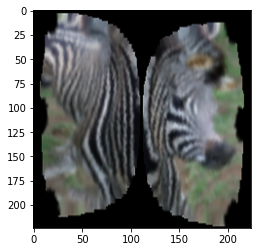

In [ ]:
index = 2
imges, label = train_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [ ]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [ ]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [ ]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

### Network model

In [ ]:
class TinyCNN(nn.Module):
    """
    TinyCNN: https://arxiv.org/abs/1911.06777v1

    fc1, fc2 should be modified for each image size and class num.

    model=TinyCNN()
    model.fc1 = nn.Linear(in_features=128 * FC_H * FC_W, out_features=N_CLASSES)
    model.fc2 = nn.Linear(in_features=100, out_features=N_CLASSES)
    """
    def __init__(self, DROPOUT=False):
        super(TinyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3,   32,  3, 1, 1, bias=False)
        self.conv2 = nn.Conv2d(32,  64,  3, 1, 1, bias=False)
        self.conv3 = nn.Conv2d(64,  128, 3, 1, 1, bias=False)
        self.conv4 = nn.Conv2d(128, 128, 3, 1, 1, bias=False)

        self.relu = nn.ReLU(inplace=False)
        self.pool = nn.MaxPool2d(2)
        
        self.fc1 = nn.Linear(128 * 8 * 8, 100)
        self.fc2 = nn.Linear(100, 10)

        self.dropout_control = DROPOUT
        self.fc1_drop = nn.Dropout2d(p=0.5)
        self.fc2_drop = nn.Dropout2d(p=0.4)

    def encode(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        return x

    def classify(self, x):
        x = x.view(x.size(0),-1)

        if(self.dropout_control):
            x = self.relu(self.fc1_drop(self.fc1(x)))
            x = self.relu(self.fc2_drop(self.fc2(x)))
        else:
            x = self.relu(self.fc1(x))
            # For easy replacement of label sizes
            # activation is assigned to forward output
            x = self.fc2(x)

        return x

    def forward(self, x):
        x = self.encode(x)
        x = self.classify(x)

        return self.relu(x)

### CONST data

In [ ]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 2
else:
    NUM_EPOCS = 50

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

### Model preparation

In [ ]:
# TinyCNN model instance set
model=TinyCNN(True)

# FC layer input&output size change
model.fc1 = nn.Linear(in_features=128 * FC_H * FC_W, out_features=100)
model.fc2 = nn.Linear(in_features=100, out_features=N_CLASSES)

model.cuda()

TinyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=20, bias=True)
  (fc1_drop): Dropout2d(p=0.5, inplace=False)
  (fc2_drop): Dropout2d(p=0.4, inplace=False)
)

### Loss function

In [ ]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Optimization method

In [ ]:
# Optimization setting
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

### Training & Test for model

In [ ]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):

    best_model=model; best_accuracy = 0;
    stats = []; training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    for epoch in range(num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_corrects = 0  # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_corrects += preds.eq(labels.view_as(preds)).sum().item()

            print(epoch_corrects)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_corrects / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if epoch%5==0:
            total_name = name+"_epoch"+str(epoch)+".pth"
            path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"
            torch.save(model.state_dict(), path)
        print('-------------')

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

In [ ]:
name = "04_simple"
best_model, stats = train_model(model, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, "simple", DEBUG)

Epoch 1/50
-------------



685
train Loss: 0.0937 Acc: 4.8362



158
val Loss: 0.0939 Acc: 4.4633
-------------
Epoch 2/50
-------------



745
train Loss: 0.0937 Acc: 5.2598



170
val Loss: 0.0939 Acc: 4.8023
-------------
Epoch 3/50
-------------



737
train Loss: 0.0937 Acc: 5.2033



192
val Loss: 0.0939 Acc: 5.4237
-------------
Epoch 4/50
-------------



759
train Loss: 0.0937 Acc: 5.3587



197
val Loss: 0.0939 Acc: 5.5650
-------------
Epoch 5/50
-------------



783
train Loss: 0.0937 Acc: 5.5281



204
val Loss: 0.0939 Acc: 5.7627
-------------
Epoch 6/50
-------------



813
train Loss: 0.0937 Acc: 5.7399



211
val Loss: 0.0939 Acc: 5.9605
-------------
Epoch 7/50
-------------



837
train Loss: 0.0936 Acc: 5.9093



242
val Loss: 0.0939 Acc: 6.8362
-------------
Epoch 8/50
-------------



828
train Loss: 0.0937 Acc: 5.8458



267
val Loss: 0.0938 Acc: 7.5424
-------------
Epoch 9/50
-------------



884
train Loss: 0.0936 Acc: 6.2412



242
val Loss: 0.0938 Acc: 6.8362
-------------
Epoch 10/50
-------------



882
train Loss: 0.0936 Acc: 6.2271



241
val Loss: 0.0938 Acc: 6.8079
-------------
Epoch 11/50
-------------



832
train Loss: 0.0937 Acc: 5.8740



241
val Loss: 0.0938 Acc: 6.8079
-------------
Epoch 12/50
-------------



863
train Loss: 0.0936 Acc: 6.0929



241
val Loss: 0.0938 Acc: 6.8079
-------------
Epoch 13/50
-------------



872
train Loss: 0.0936 Acc: 6.1565



241
val Loss: 0.0938 Acc: 6.8079
-------------
Epoch 14/50
-------------



878
train Loss: 0.0936 Acc: 6.1988



241
val Loss: 0.0938 Acc: 6.8079
-------------
Epoch 15/50
-------------



920
train Loss: 0.0936 Acc: 6.4953



241
val Loss: 0.0938 Acc: 6.8079
-------------
Epoch 16/50
-------------



903
train Loss: 0.0936 Acc: 6.3753



241
val Loss: 0.0938 Acc: 6.8079
-------------
Epoch 17/50
-------------



881
train Loss: 0.0936 Acc: 6.2200



241
val Loss: 0.0938 Acc: 6.8079
-------------
Epoch 18/50
-------------



887
train Loss: 0.0936 Acc: 6.2624



241
val Loss: 0.0938 Acc: 6.8079
-------------
Epoch 19/50
-------------



928
train Loss: 0.0935 Acc: 6.5518



241
val Loss: 0.0937 Acc: 6.8079
-------------
Epoch 20/50
-------------



944
train Loss: 0.0935 Acc: 6.6648



241
val Loss: 0.0937 Acc: 6.8079
-------------
Epoch 21/50
-------------



966
train Loss: 0.0935 Acc: 6.8201



242
val Loss: 0.0937 Acc: 6.8362
-------------
Epoch 22/50
-------------



981
train Loss: 0.0935 Acc: 6.9260



243
val Loss: 0.0937 Acc: 6.8644
-------------
Epoch 23/50
-------------



1016
train Loss: 0.0934 Acc: 7.1731



249
val Loss: 0.0936 Acc: 7.0339
-------------
Epoch 24/50
-------------



1070
train Loss: 0.0934 Acc: 7.5544



261
val Loss: 0.0935 Acc: 7.3729
-------------
Epoch 25/50
-------------



1090
train Loss: 0.0934 Acc: 7.6956



338
val Loss: 0.0935 Acc: 9.5480
-------------
Epoch 26/50
-------------



1196
train Loss: 0.0932 Acc: 8.4439



392
val Loss: 0.0933 Acc: 11.0734
-------------
Epoch 27/50
-------------



1189
train Loss: 0.0931 Acc: 8.3945



407
val Loss: 0.0931 Acc: 11.4972
-------------
Epoch 28/50
-------------



1294
train Loss: 0.0929 Acc: 9.1358



394
val Loss: 0.0928 Acc: 11.1299
-------------
Epoch 29/50
-------------



1348
train Loss: 0.0926 Acc: 9.5171



397
val Loss: 0.0923 Acc: 11.2147
-------------
Epoch 30/50
-------------



1379
train Loss: 0.0922 Acc: 9.7360



395
val Loss: 0.0917 Acc: 11.1582
-------------
Epoch 31/50
-------------



1401
train Loss: 0.0919 Acc: 9.8913



396
val Loss: 0.0912 Acc: 11.1864
-------------
Epoch 32/50
-------------



1543
train Loss: 0.0917 Acc: 10.8938



420
val Loss: 0.0908 Acc: 11.8644
-------------
Epoch 33/50
-------------



1501
train Loss: 0.0914 Acc: 10.5973



430
val Loss: 0.0905 Acc: 12.1469
-------------
Epoch 34/50
-------------



1532
train Loss: 0.0914 Acc: 10.8162



466
val Loss: 0.0903 Acc: 13.1638
-------------
Epoch 35/50
-------------



1502
train Loss: 0.0914 Acc: 10.6043



480
val Loss: 0.0901 Acc: 13.5593
-------------
Epoch 36/50
-------------



1592
train Loss: 0.0911 Acc: 11.2398



527
val Loss: 0.0899 Acc: 14.8870
-------------
Epoch 37/50
-------------



1628
train Loss: 0.0911 Acc: 11.4939



539
val Loss: 0.0900 Acc: 15.2260
-------------
Epoch 38/50
-------------



1633
train Loss: 0.0910 Acc: 11.5292



532
val Loss: 0.0899 Acc: 15.0282
-------------
Epoch 39/50
-------------



1667
train Loss: 0.0909 Acc: 11.7693



575
val Loss: 0.0896 Acc: 16.2429
-------------
Epoch 40/50
-------------



1660
train Loss: 0.0910 Acc: 11.7199



571
val Loss: 0.0898 Acc: 16.1299
-------------
Epoch 41/50
-------------



1741
train Loss: 0.0908 Acc: 12.2917



591
val Loss: 0.0894 Acc: 16.6949
-------------
Epoch 42/50
-------------



1700
train Loss: 0.0906 Acc: 12.0023



579
val Loss: 0.0892 Acc: 16.3559
-------------
Epoch 43/50
-------------



1777
train Loss: 0.0907 Acc: 12.5459



581
val Loss: 0.0893 Acc: 16.4124
-------------
Epoch 44/50
-------------



1798
train Loss: 0.0907 Acc: 12.6942



583
val Loss: 0.0892 Acc: 16.4689
-------------
Epoch 45/50
-------------



1838
train Loss: 0.0904 Acc: 12.9766



594
val Loss: 0.0891 Acc: 16.7797
-------------
Epoch 46/50
-------------



1830
train Loss: 0.0903 Acc: 12.9201



605
val Loss: 0.0889 Acc: 17.0904
-------------
Epoch 47/50
-------------



1852
train Loss: 0.0904 Acc: 13.0754



593
val Loss: 0.0888 Acc: 16.7514
-------------
Epoch 48/50
-------------



1835
train Loss: 0.0906 Acc: 12.9554



588
val Loss: 0.0889 Acc: 16.6102
-------------
Epoch 49/50
-------------



1863
train Loss: 0.0903 Acc: 13.1531



608
val Loss: 0.0889 Acc: 17.1751
-------------
Epoch 50/50
-------------



1903
train Loss: 0.0902 Acc: 13.4355



617
val Loss: 0.0887 Acc: 17.4294
-------------
Lowest training loss 0.09015298913138561
Lowest validation loss 0.08865492034093135
Highest training accuracy 13.435470206156452
Highest validation accuracy 17.429378531073446
-------------


In [ ]:
# Save weights
path = F"/content/drive/My Drive/Colab Notebooks/PhD/simple/{name}.pth"
torch.save(best_model.state_dict(), path)

/content/drive/My Drive/Colab Notebooks/Graphs/04_simple_Loss _.png04_simple_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/04_simple_Accuracy _.png04_simple_Accuracy _.png


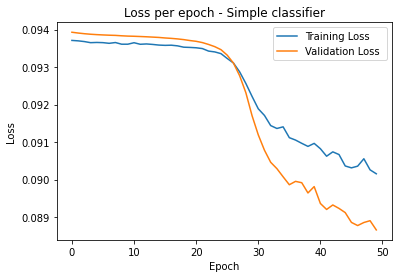

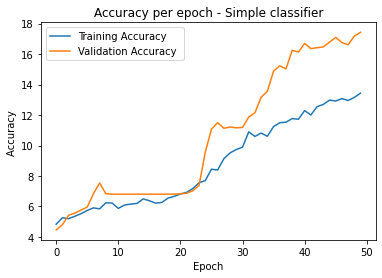

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 2.8377 
Testing Accuracy: 295/2000 (14.75%)
apple Class Accuracy: 0/100 (0.00%)
banana Class Accuracy: 9/100 (9.00%)
bear Class Accuracy: 60/100 (60.00%)
bell_pepper Class Accuracy: 0/100 (0.00%)
bird Class Accuracy: 39/100 (39.00%)
broccoli Class Accuracy: 0/100 (0.00%)
cat Class Accuracy: 6/100 (6.00%)
cauliflower Class Accuracy: 0/100 (0.00%)
cow Class Accuracy: 38/100 (38.00%)
dog Class Accuracy: 0/100 (0.00%)
elephant Class Accuracy: 0/100 (0.00%)
fox Class Accuracy: 23/100 (23.00%)
goat Class Accuracy: 0/100 (0.00%)
horse Class Accuracy: 0/100 (0.00%)
mashed_potato Class Accuracy: 0/100 (0.00%)
orange Class Accuracy: 59/100 (59.00%)
pineapple Class Accuracy: 1/100 (1.00%)
pomegranate Class Accuracy: 60/100 (60.00%)
tomato Class Accuracy: 0/100 (0.00%)
zebra Class Accuracy: 0/100 (0.00%)
Classifier has Acc=0.147 P=0.147 R=0.111 F1=0.082


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        apple       0.00      0.00      0.00       100
       banana       0.15      0.09      0.11       100
         bear       0.27      0.60      0.37       100
  bell_pepper       0.00      0.00      0.00       100
         bird       0.09      0.39      0.14       100
     broccoli       0.00      0.00      0.00       100
          cat       0.08      0.06      0.07       100
  cauliflower       0.00      0.00      0.00       100
          cow       0.12      0.38      0.18       100
          dog       0.00      0.00      0.00       100
     elephant       0.00      0.00      0.00       100
          fox       0.12      0.23      0.16       100
         goat       0.00      0.00      0.00       100
        horse       0.00      0.00      0.00       100
mashed_potato       0.00      0.00      0.00       100
       orange       0.25      0.59      0.35       100
    pineapple       1.00      0.01      0.02       100
  pomegra

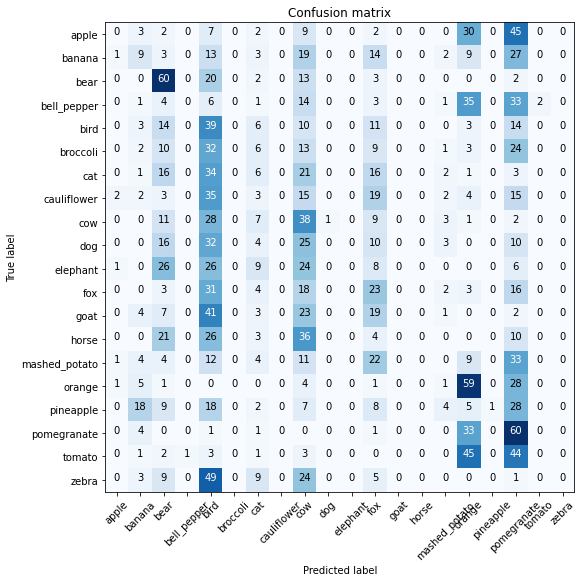

In [ ]:
result = test_model(best_model, criterion, name)

## VGG16 transfer learning

In [ ]:
# Load pre-trained VGG-16
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

# Replacement last layer output for 20 classes
net.classifier[6] = nn.Linear(in_features=4096, out_features=N_CLASSES)

net.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Store parameters through transfer learning, which are re-trained
params_to_update = []

# Re-trained params
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# Non re-trained params keep their grads
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# Check params_to_update contents
print("-----------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[ 0.0027,  0.0131,  0.0134,  ...,  0.0006,  0.0019,  0.0070],
        [ 0.0132, -0.0132,  0.0094,  ...,  0.0109,  0.0072,  0.0094],
        [-0.0086, -0.0096, -0.0050,  ...,  0.0125,  0.0065,  0.0153],
        ...,
        [-0.0099,  0.0040, -0.0119,  ...,  0.0130,  0.0060,  0.0030],
        [-0.0013, -0.0108, -0.0121,  ...,  0.0057, -0.0025, -0.0129],
        [-0.0030,  0.0066, -0.0107,  ..., -0.0149, -0.0028,  0.0142]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.0084,  0.0109,  0.0063,  0.0060, -0.0020,  0.0045,  0.0014, -0.0012,
         0.0037, -0.0101, -0.0003,  0.0090,  0.0146,  0.0047,  0.0065,  0.0067,
        -0.0013,  0.0125,  0.0128, -0.0141], device='cuda:0',
       requires_grad=True)]


### VGG optimizer

In [ ]:
vgg_optimizer = optim.SGD(params=params_to_update, lr=0.0001, momentum=0.9)

In [ ]:
name = "04_VGG_transfer"
best_vgg, stats_vgg = train_model(net, dataloaders_dict, criterion, vgg_optimizer, NUM_EPOCS, name, "VGG_transfer", DEBUG)

Epoch 1/50
-------------



2040
train Loss: 0.0879 Acc: 14.4027



1013
val Loss: 0.0791 Acc: 28.6158
-------------
Epoch 2/50
-------------



3550
train Loss: 0.0778 Acc: 25.0635



1225
val Loss: 0.0723 Acc: 34.6045
-------------
Epoch 3/50
-------------



4215
train Loss: 0.0728 Acc: 29.7585



1345
val Loss: 0.0684 Acc: 37.9944
-------------
Epoch 4/50
-------------



4565
train Loss: 0.0697 Acc: 32.2296



1383
val Loss: 0.0658 Acc: 39.0678
-------------
Epoch 5/50
-------------



4784
train Loss: 0.0679 Acc: 33.7758



1414
val Loss: 0.0640 Acc: 39.9435
-------------
Epoch 6/50
-------------



4868
train Loss: 0.0666 Acc: 34.3688



1473
val Loss: 0.0626 Acc: 41.6102
-------------
Epoch 7/50
-------------



5047
train Loss: 0.0654 Acc: 35.6326



1488
val Loss: 0.0616 Acc: 42.0339
-------------
Epoch 8/50
-------------



5143
train Loss: 0.0644 Acc: 36.3104



1528
val Loss: 0.0606 Acc: 43.1638
-------------
Epoch 9/50
-------------



5138
train Loss: 0.0637 Acc: 36.2751



1497
val Loss: 0.0599 Acc: 42.2881
-------------
Epoch 10/50
-------------



5232
train Loss: 0.0632 Acc: 36.9387



1535
val Loss: 0.0592 Acc: 43.3616
-------------
Epoch 11/50
-------------



5286
train Loss: 0.0625 Acc: 37.3200



1560
val Loss: 0.0587 Acc: 44.0678
-------------
Epoch 12/50
-------------



5368
train Loss: 0.0623 Acc: 37.8989



1554
val Loss: 0.0582 Acc: 43.8983
-------------
Epoch 13/50
-------------



5433
train Loss: 0.0618 Acc: 38.3578



1579
val Loss: 0.0578 Acc: 44.6045
-------------
Epoch 14/50
-------------



5472
train Loss: 0.0613 Acc: 38.6332



1571
val Loss: 0.0574 Acc: 44.3785
-------------
Epoch 15/50
-------------



5505
train Loss: 0.0608 Acc: 38.8661



1580
val Loss: 0.0571 Acc: 44.6328
-------------
Epoch 16/50
-------------



5540
train Loss: 0.0607 Acc: 39.1132



1596
val Loss: 0.0567 Acc: 45.0847
-------------
Epoch 17/50
-------------



5596
train Loss: 0.0604 Acc: 39.5086



1590
val Loss: 0.0565 Acc: 44.9153
-------------
Epoch 18/50
-------------



5631
train Loss: 0.0601 Acc: 39.7557



1600
val Loss: 0.0561 Acc: 45.1977
-------------
Epoch 19/50
-------------



5578
train Loss: 0.0601 Acc: 39.3815



1588
val Loss: 0.0559 Acc: 44.8588
-------------
Epoch 20/50
-------------



5652
train Loss: 0.0597 Acc: 39.9040



1632
val Loss: 0.0557 Acc: 46.1017
-------------
Epoch 21/50
-------------



5615
train Loss: 0.0595 Acc: 39.6428



1601
val Loss: 0.0554 Acc: 45.2260
-------------
Epoch 22/50
-------------



5695
train Loss: 0.0593 Acc: 40.2076



1621
val Loss: 0.0552 Acc: 45.7910
-------------
Epoch 23/50
-------------



5720
train Loss: 0.0591 Acc: 40.3841



1631
val Loss: 0.0551 Acc: 46.0734
-------------
Epoch 24/50
-------------



5762
train Loss: 0.0593 Acc: 40.6806



1606
val Loss: 0.0549 Acc: 45.3672
-------------
Epoch 25/50
-------------



5785
train Loss: 0.0590 Acc: 40.8430



1630
val Loss: 0.0547 Acc: 46.0452
-------------
Epoch 26/50
-------------



5763
train Loss: 0.0588 Acc: 40.6877



1624
val Loss: 0.0547 Acc: 45.8757
-------------
Epoch 27/50
-------------



5740
train Loss: 0.0587 Acc: 40.5253



1627
val Loss: 0.0544 Acc: 45.9605
-------------
Epoch 28/50
-------------



5750
train Loss: 0.0587 Acc: 40.5959



1651
val Loss: 0.0543 Acc: 46.6384
-------------
Epoch 29/50
-------------



5807
train Loss: 0.0582 Acc: 40.9983



1634
val Loss: 0.0543 Acc: 46.1582
-------------
Epoch 30/50
-------------



5863
train Loss: 0.0582 Acc: 41.3937



1642
val Loss: 0.0540 Acc: 46.3842
-------------
Epoch 31/50
-------------



5840
train Loss: 0.0581 Acc: 41.2313



1621
val Loss: 0.0539 Acc: 45.7910
-------------
Epoch 32/50
-------------



5825
train Loss: 0.0582 Acc: 41.1254



1641
val Loss: 0.0539 Acc: 46.3559
-------------
Epoch 33/50
-------------



5920
train Loss: 0.0579 Acc: 41.7961



1655
val Loss: 0.0538 Acc: 46.7514
-------------
Epoch 34/50
-------------



5848
train Loss: 0.0581 Acc: 41.2878



1634
val Loss: 0.0537 Acc: 46.1582
-------------
Epoch 35/50
-------------



5926
train Loss: 0.0575 Acc: 41.8385



1647
val Loss: 0.0536 Acc: 46.5254
-------------
Epoch 36/50
-------------



5899
train Loss: 0.0577 Acc: 41.6478



1644
val Loss: 0.0536 Acc: 46.4407
-------------
Epoch 37/50
-------------



5982
train Loss: 0.0575 Acc: 42.2338



1633
val Loss: 0.0536 Acc: 46.1299
-------------
Epoch 38/50
-------------



5914
train Loss: 0.0573 Acc: 41.7537



1657
val Loss: 0.0534 Acc: 46.8079
-------------
Epoch 39/50
-------------



6011
train Loss: 0.0574 Acc: 42.4386



1676
val Loss: 0.0533 Acc: 47.3446
-------------
Epoch 40/50
-------------



5927
train Loss: 0.0575 Acc: 41.8455



1675
val Loss: 0.0532 Acc: 47.3164
-------------
Epoch 41/50
-------------



6013
train Loss: 0.0572 Acc: 42.4527



1688
val Loss: 0.0532 Acc: 47.6836
-------------
Epoch 42/50
-------------



6014
train Loss: 0.0570 Acc: 42.4598



1688
val Loss: 0.0530 Acc: 47.6836
-------------
Epoch 43/50
-------------



5962
train Loss: 0.0568 Acc: 42.0926



1684
val Loss: 0.0530 Acc: 47.5706
-------------
Epoch 44/50
-------------



5999
train Loss: 0.0569 Acc: 42.3539



1688
val Loss: 0.0529 Acc: 47.6836
-------------
Epoch 45/50
-------------



5948
train Loss: 0.0571 Acc: 41.9938



1664
val Loss: 0.0529 Acc: 47.0056
-------------
Epoch 46/50
-------------



5969
train Loss: 0.0569 Acc: 42.1421



1677
val Loss: 0.0528 Acc: 47.3729
-------------
Epoch 47/50
-------------



6058
train Loss: 0.0567 Acc: 42.7704



1682
val Loss: 0.0527 Acc: 47.5141
-------------
Epoch 48/50
-------------



5969
train Loss: 0.0570 Acc: 42.1421



1708
val Loss: 0.0526 Acc: 48.2486
-------------
Epoch 49/50
-------------



6077
train Loss: 0.0568 Acc: 42.9045



1704
val Loss: 0.0525 Acc: 48.1356
-------------
Epoch 50/50
-------------



6095
train Loss: 0.0566 Acc: 43.0316



1689
val Loss: 0.0524 Acc: 47.7119
-------------
Lowest training loss 0.05659329560441979
Lowest validation loss 0.052444275658009416
Highest training accuracy 43.03162948319684
Highest validation accuracy 48.24858757062147
-------------


In [ ]:
# Save weights
path = F"/content/drive/My Drive/Colab Notebooks/PhD/VGG_transfer/{name}.pth"
torch.save(best_vgg.state_dict(), path)

/content/drive/My Drive/Colab Notebooks/Graphs/04_VGG_transfer_Loss _.png04_VGG_transfer_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/04_VGG_transfer_Accuracy _.png04_VGG_transfer_Accuracy _.png


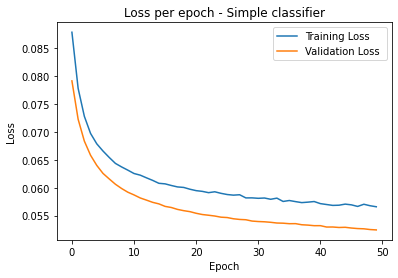

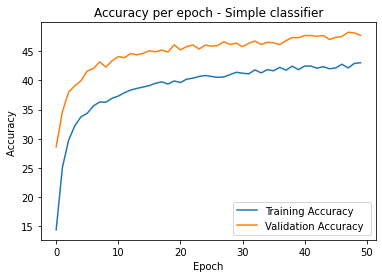

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats_vgg[0],stats_vgg[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats_vgg[1],stats_vgg[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 1.7868 
Testing Accuracy: 840/2000 (42.00%)
apple Class Accuracy: 38/100 (38.00%)
banana Class Accuracy: 37/100 (37.00%)
bear Class Accuracy: 46/100 (46.00%)
bell_pepper Class Accuracy: 48/100 (48.00%)
bird Class Accuracy: 24/100 (24.00%)
broccoli Class Accuracy: 56/100 (56.00%)
cat Class Accuracy: 26/100 (26.00%)
cauliflower Class Accuracy: 32/100 (32.00%)
cow Class Accuracy: 38/100 (38.00%)
dog Class Accuracy: 16/100 (16.00%)
elephant Class Accuracy: 67/100 (67.00%)
fox Class Accuracy: 45/100 (45.00%)
goat Class Accuracy: 17/100 (17.00%)
horse Class Accuracy: 21/100 (21.00%)
mashed_potato Class Accuracy: 67/100 (67.00%)
orange Class Accuracy: 52/100 (52.00%)
pineapple Class Accuracy: 44/100 (44.00%)
pomegranate Class Accuracy: 66/100 (66.00%)
tomato Class Accuracy: 37/100 (37.00%)
zebra Class Accuracy: 63/100 (63.00%)
Classifier has Acc=0.420 P=0.420 R=0.438 F1=0.415
               precision    recall  f1-score   support

        apple       0.50      0.38      0.43      

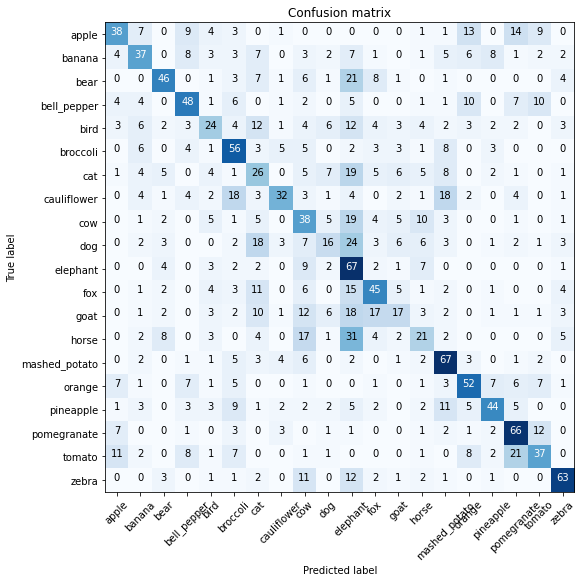

In [ ]:
result = test_model(best_vgg, criterion, name)

### VGG16 fine tuning

In [ ]:
# Load pre-trained VGG-16
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

# Replacement last layer output for 20 classes
net.classifier[6] = nn.Linear(in_features=4096, out_features=N_CLASSES)

net.cuda()

In [ ]:
# Store parameters through transfer learning, which are re-trained
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# Re-trained params
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# Non re-trained params keep their grads
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1 stores：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2 stores：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3 stores：", name)

    else:
        param.requires_grad = False
        print("Freazed：", name)

In [ ]:
vgg_optimizer2 = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

In [ ]:
name = "04_VGG_fine"
best_vgg2, stats_vgg2 = train_model(net, dataloaders_dict, criterion, vgg_optimizer2, NUM_EPOCS, name, "VGG_fine", DEBUG)

Epoch 1/50
-------------



5994
train Loss: 0.0563 Acc: 42.3186



2232
val Loss: 0.0364 Acc: 63.0508
-------------
Epoch 2/50
-------------



8987
train Loss: 0.0352 Acc: 63.4496



2440
val Loss: 0.0304 Acc: 68.9266
-------------
Epoch 3/50
-------------



9814
train Loss: 0.0287 Acc: 69.2883



2516
val Loss: 0.0280 Acc: 71.0734
-------------
Epoch 4/50
-------------



10447
train Loss: 0.0244 Acc: 73.7574



2582
val Loss: 0.0258 Acc: 72.9379
-------------
Epoch 5/50
-------------



10950
train Loss: 0.0212 Acc: 77.3087



2574
val Loss: 0.0256 Acc: 72.7119
-------------
Epoch 6/50
-------------



11461
train Loss: 0.0179 Acc: 80.9164



2619
val Loss: 0.0255 Acc: 73.9831
-------------
Epoch 7/50
-------------



11792
train Loss: 0.0154 Acc: 83.2533



2667
val Loss: 0.0250 Acc: 75.3390
-------------
Epoch 8/50
-------------



12231
train Loss: 0.0128 Acc: 86.3527



2655
val Loss: 0.0261 Acc: 75.0000
-------------
Epoch 9/50
-------------



12570
train Loss: 0.0105 Acc: 88.7461



2604
val Loss: 0.0282 Acc: 73.5593
-------------
Epoch 10/50
-------------



12841
train Loss: 0.0085 Acc: 90.6594



2669
val Loss: 0.0279 Acc: 75.3955
-------------
Epoch 11/50
-------------



13084
train Loss: 0.0071 Acc: 92.3750



2678
val Loss: 0.0284 Acc: 75.6497
-------------
Epoch 12/50
-------------



13257
train Loss: 0.0058 Acc: 93.5964



2669
val Loss: 0.0302 Acc: 75.3955
-------------
Epoch 13/50
-------------



13474
train Loss: 0.0045 Acc: 95.1285



2684
val Loss: 0.0309 Acc: 75.8192
-------------
Epoch 14/50
-------------



13629
train Loss: 0.0035 Acc: 96.2228



2688
val Loss: 0.0326 Acc: 75.9322
-------------
Epoch 15/50
-------------



13704
train Loss: 0.0031 Acc: 96.7523



2665
val Loss: 0.0340 Acc: 75.2825
-------------
Epoch 16/50
-------------



13784
train Loss: 0.0026 Acc: 97.3171



2691
val Loss: 0.0346 Acc: 76.0169
-------------
Epoch 17/50
-------------



13858
train Loss: 0.0021 Acc: 97.8396



2694
val Loss: 0.0373 Acc: 76.1017
-------------
Epoch 18/50
-------------



13878
train Loss: 0.0020 Acc: 97.9808



2670
val Loss: 0.0365 Acc: 75.4237
-------------
Epoch 19/50
-------------



13909
train Loss: 0.0017 Acc: 98.1997



2656
val Loss: 0.0373 Acc: 75.0282
-------------
Epoch 20/50
-------------



13967
train Loss: 0.0014 Acc: 98.6091



2679
val Loss: 0.0401 Acc: 75.6780
-------------
Epoch 21/50
-------------



14002
train Loss: 0.0012 Acc: 98.8563



2682
val Loss: 0.0395 Acc: 75.7627
-------------
Epoch 22/50
-------------



13987
train Loss: 0.0013 Acc: 98.7504



2702
val Loss: 0.0377 Acc: 76.3277
-------------
Epoch 23/50
-------------



14031
train Loss: 0.0010 Acc: 99.0610



2694
val Loss: 0.0411 Acc: 76.1017
-------------
Epoch 24/50
-------------



14039
train Loss: 0.0010 Acc: 99.1175



2705
val Loss: 0.0400 Acc: 76.4124
-------------
Epoch 25/50
-------------



14056
train Loss: 0.0008 Acc: 99.2375



2692
val Loss: 0.0425 Acc: 76.0452
-------------
Epoch 26/50
-------------



14051
train Loss: 0.0008 Acc: 99.2022



2652
val Loss: 0.0429 Acc: 74.9153
-------------
Epoch 27/50
-------------



14028
train Loss: 0.0009 Acc: 99.0398



2675
val Loss: 0.0427 Acc: 75.5650
-------------
Epoch 28/50
-------------



14054
train Loss: 0.0008 Acc: 99.2234



2698
val Loss: 0.0422 Acc: 76.2147
-------------
Epoch 29/50
-------------



14060
train Loss: 0.0007 Acc: 99.2657



2695
val Loss: 0.0432 Acc: 76.1299
-------------
Epoch 30/50
-------------



14079
train Loss: 0.0006 Acc: 99.3999



2685
val Loss: 0.0449 Acc: 75.8475
-------------
Epoch 31/50
-------------



14096
train Loss: 0.0005 Acc: 99.5199



2696
val Loss: 0.0437 Acc: 76.1582
-------------
Epoch 32/50
-------------



14078
train Loss: 0.0006 Acc: 99.3928



2679
val Loss: 0.0454 Acc: 75.6780
-------------
Epoch 33/50
-------------



14095
train Loss: 0.0005 Acc: 99.5128



2688
val Loss: 0.0463 Acc: 75.9322
-------------
Epoch 34/50
-------------



14091
train Loss: 0.0005 Acc: 99.4846



2687
val Loss: 0.0451 Acc: 75.9040
-------------
Epoch 35/50
-------------



14111
train Loss: 0.0004 Acc: 99.6258



2690
val Loss: 0.0448 Acc: 75.9887
-------------
Epoch 36/50
-------------



14101
train Loss: 0.0005 Acc: 99.5552



2687
val Loss: 0.0448 Acc: 75.9040
-------------
Epoch 37/50
-------------



14100
train Loss: 0.0005 Acc: 99.5482



2703
val Loss: 0.0436 Acc: 76.3559
-------------
Epoch 38/50
-------------



14094
train Loss: 0.0005 Acc: 99.5058



2694
val Loss: 0.0453 Acc: 76.1017
-------------
Epoch 39/50
-------------



14117
train Loss: 0.0003 Acc: 99.6682



2691
val Loss: 0.0458 Acc: 76.0169
-------------
Epoch 40/50
-------------



14115
train Loss: 0.0003 Acc: 99.6541



2689
val Loss: 0.0481 Acc: 75.9605
-------------
Epoch 41/50
-------------



14117
train Loss: 0.0003 Acc: 99.6682



2686
val Loss: 0.0477 Acc: 75.8757
-------------
Epoch 42/50
-------------



14113
train Loss: 0.0004 Acc: 99.6399



2689
val Loss: 0.0466 Acc: 75.9605
-------------
Epoch 43/50
-------------



14108
train Loss: 0.0004 Acc: 99.6046



2705
val Loss: 0.0461 Acc: 76.4124
-------------
Epoch 44/50
-------------



14123
train Loss: 0.0003 Acc: 99.7105



2701
val Loss: 0.0465 Acc: 76.2994
-------------
Epoch 45/50
-------------



14116
train Loss: 0.0003 Acc: 99.6611



2699
val Loss: 0.0498 Acc: 76.2429
-------------
Epoch 46/50
-------------



14126
train Loss: 0.0003 Acc: 99.7317



2687
val Loss: 0.0467 Acc: 75.9040
-------------
Epoch 47/50
-------------



14136
train Loss: 0.0002 Acc: 99.8023



2715
val Loss: 0.0498 Acc: 76.6949
-------------
Epoch 48/50
-------------



14123
train Loss: 0.0003 Acc: 99.7105



2681
val Loss: 0.0499 Acc: 75.7345
-------------
Epoch 49/50
-------------



14117
train Loss: 0.0003 Acc: 99.6682



2678
val Loss: 0.0496 Acc: 75.6497
-------------
Epoch 50/50
-------------



14139
train Loss: 0.0002 Acc: 99.8235



2714
val Loss: 0.0495 Acc: 76.6667
-------------
Lowest training loss 0.00021743128245443923
Lowest validation loss 0.024959215269250386
Highest training accuracy 99.82349618751765
Highest validation accuracy 76.69491525423729
-------------


In [ ]:
# Save weights
path = F"/content/drive/My Drive/Colab Notebooks/PhD/VGG_fine/{name}.pth"
torch.save(best_vgg2.state_dict(), path)

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats_vgg2[0],stats_vgg2[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats_vgg2[1],stats_vgg2[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 1.9064 
Testing Accuracy: 1458/2000 (72.90%)
apple Class Accuracy: 49/100 (49.00%)
banana Class Accuracy: 62/100 (62.00%)
bear Class Accuracy: 84/100 (84.00%)
bell_pepper Class Accuracy: 76/100 (76.00%)
bird Class Accuracy: 77/100 (77.00%)
broccoli Class Accuracy: 92/100 (92.00%)
cat Class Accuracy: 75/100 (75.00%)
cauliflower Class Accuracy: 58/100 (58.00%)
cow Class Accuracy: 50/100 (50.00%)
dog Class Accuracy: 51/100 (51.00%)
elephant Class Accuracy: 82/100 (82.00%)
fox Class Accuracy: 86/100 (86.00%)
goat Class Accuracy: 55/100 (55.00%)
horse Class Accuracy: 66/100 (66.00%)
mashed_potato Class Accuracy: 76/100 (76.00%)
orange Class Accuracy: 86/100 (86.00%)
pineapple Class Accuracy: 88/100 (88.00%)
pomegranate Class Accuracy: 80/100 (80.00%)
tomato Class Accuracy: 75/100 (75.00%)
zebra Class Accuracy: 90/100 (90.00%)
Classifier has Acc=0.729 P=0.729 R=0.732 F1=0.724
               precision    recall  f1-score   support

        apple       0.70      0.49      0.58     

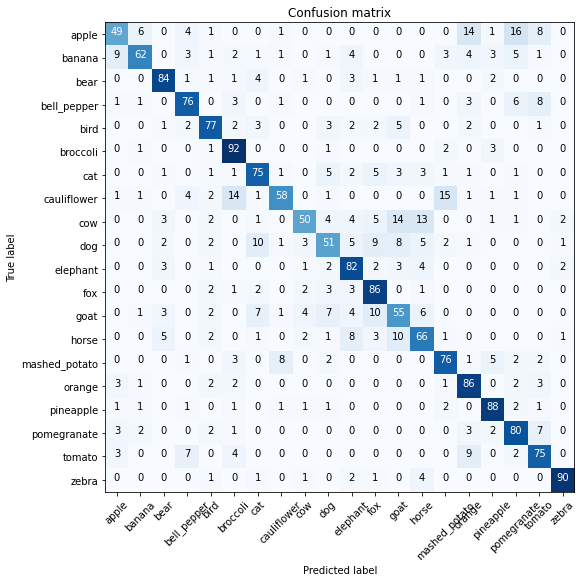

In [ ]:
result = test_model(best_vgg2,criterion, name)